<a href="https://colab.research.google.com/github/McIlwee-Nevan/CS482-Final-Project_BeierMamarilMcIlwee/blob/main/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rtatman/deceptive-opinion-spam-corpus")

print("Path to dataset files:", path)

100%|██████████| 456k/456k [00:00<00:00, 20.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/rtatman/deceptive-opinion-spam-corpus/versions/2


Import Dataset and Preprocess

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

data = pd.read_csv(path+"/deceptive-opinion.csv")
X = np.copy(data['text'])
y = np.copy(data['deceptive'])
y = np.array(y == 'truthful').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


Next, build and evaluate the models:

In [3]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define classifiers
classifiers = [
    LinearRegression(),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=20),
    XGBClassifier()
]

# Define classifier labels
classifier_labels = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']

accuracies = np.zeros(4)
precision = np.zeros(4)
recall = np.zeros(4)
f1 = np.zeros(4)
support = np.zeros(4)

index = 0
for model in classifiers:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if isinstance(model, LinearRegression):
        accuracies[index] = r2_score(y_test, y_pred)
        print(f'{classifier_labels[index]} R^2 Score: {accuracies[index]:.4f}')
    else:
        accuracies[index] = accuracy_score(y_true=y_test, y_pred=y_pred)
        precision_score, recall_score, f1_score, support_score = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, average='binary')
        precision[index] = precision_score
        recall[index] = recall_score
        f1[index] = f1_score
        support[index] = support_score
        print(f'{classifier_labels[index]} Accuracy: {accuracies[index]:.4f}')
        print(f'{classifier_labels[index]} Precision: {precision[index]:.4f}, Recall: {recall[index]:.4f}, F1 Score: {f1[index]:.4f}')

    index += 1

Linear Regression R^2 Score: 0.5049
Decision Tree Accuracy: 0.7000
Decision Tree Precision: 0.7143, Recall: 0.7143, F1 Score: 0.7143
Random Forest Accuracy: 0.8219
Random Forest Precision: 0.8627, Recall: 0.7857, F1 Score: 0.8224
XGBoost Accuracy: 0.7969
XGBoost Precision: 0.8160, Recall: 0.7917, F1 Score: 0.8036


Train and Test Neural Network

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Create tensors from data set, create data loaders
X_test_tensor, X_val, y_test_tensor, y_val = train_test_split(X_test, y_test, train_size=0.5)

X_train_tensor = torch.from_numpy(X_train.todense()).to(torch.float32)
X_test_tensor = torch.from_numpy(X_test_tensor.todense()).to(torch.float32)
X_val_tensor = torch.from_numpy(X_val.todense()).to(torch.float32)
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test_tensor)
y_val_tensor = torch.from_numpy(y_val)

train_loader = DataLoader(list(zip(X_train_tensor, y_train_tensor)), batch_size=64, shuffle=True)
val_loader = DataLoader(list(zip(X_val_tensor, y_val_tensor)), batch_size=64, shuffle=True)
test_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), batch_size=64, shuffle=True)

In [7]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim : int):
        super(NeuralNet, self).__init__()

        self.fc1 = nn.Linear(input_dim, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 2)

        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc4(out))

        return out

In [8]:
# Initialize model and choose criterion/optimizer
nn_model = NeuralNet(8703)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [11]:
# Train model
num_epochs = 10
train_loss = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)

for epoch in range(num_epochs):
    nn_model.train()

    for (x, y) in train_loader:
        x, y = x.to(device), y.to(device)

        z = nn_model.forward(x)
        loss_1 = criterion(z, y)
        optimizer.zero_grad()
        loss_1.backward()
        optimizer.step()

    nn_model.eval()

    for (x,y) in val_loader:
        x, y = x.to(device), y.to(device)

        z = nn_model(x)
        loss_2 = criterion(z, y)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_1.item():.4f}, Validation Loss: {loss_2.item():.4f}')
    train_loss[epoch] = loss_1.item()
    val_loss[epoch] = loss_2.item()

Epoch [1/10], Train Loss: 0.0116, Validation Loss: 0.5306107401847839
Epoch [2/10], Train Loss: 0.0024, Validation Loss: 0.7374682426452637
Epoch [3/10], Train Loss: 0.0004, Validation Loss: 0.3318140208721161
Epoch [4/10], Train Loss: 0.0002, Validation Loss: 0.7336854338645935
Epoch [5/10], Train Loss: 0.0001, Validation Loss: 0.07804688066244125
Epoch [6/10], Train Loss: 0.0001, Validation Loss: 0.4625616669654846
Epoch [7/10], Train Loss: 0.0001, Validation Loss: 0.5101990699768066
Epoch [8/10], Train Loss: 0.0000, Validation Loss: 0.3489060401916504
Epoch [9/10], Train Loss: 0.0001, Validation Loss: 0.3650752007961273
Epoch [10/10], Train Loss: 0.0000, Validation Loss: 0.5003432035446167


In [12]:
def evaluate_model(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for (x, y) in data_loader:
            x, y = x.to(device), y.to(device)  # Move data to GPU
            z = model(x)
            _, predicted = torch.max(z, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

In [14]:
# Get accuracy and print report
y_true, y_pred = evaluate_model(nn_model, test_loader)
print("Classification Report: \n", classification_report(y_true, y_pred))
print("Accuracy: ", accuracy_score(y_true, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.93      0.91        87
           1       0.91      0.85      0.88        73

    accuracy                           0.89       160
   macro avg       0.90      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160

Accuracy:  0.89375


In [16]:
# Save epochs, loss, and parameters
torch.save({
            'epoch': num_epochs,
            'model_state_dict': nn_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train loss': train_loss[-1],
            'validation loss': val_loss[-1]
            }, './nn_model.pt')

from google.colab import files
files.download('./nn_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plots:

In [17]:
import matplotlib.pyplot as plt

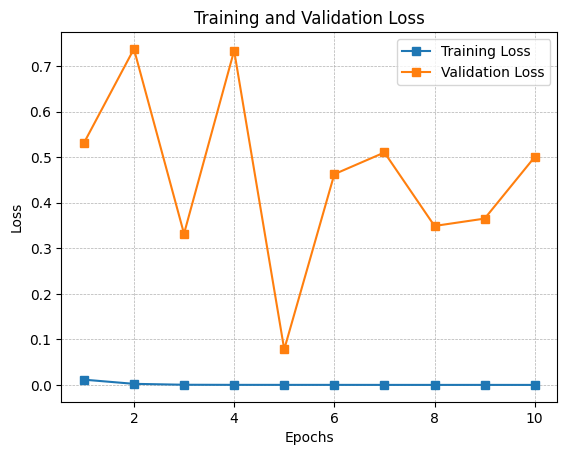

In [30]:
epochs = range(1, num_epochs + 1)
# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss', marker='s')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
# plt.xticks(np.arange(0, num_epochs, 10))

# Display the plot
plt.legend(loc='best')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

# Command Line Interface:

In [21]:
import torch.nn.functional as F

user_review = input("Enter a review: ")

user_review = vectorizer.transform([user_review])
user_review = torch.from_numpy(user_review.todense()).to(torch.float32)

neural_network = NeuralNet(8703)

output = neural_network.forward(user_review)

probabilities = F.softmax(output, dim=1)

predicted_class = torch.argmax(probabilities, dim=1).item()

print("truthful" if not predicted_class else "deceptive")

Enter a review: Clean, freshly beautifully designed and we had a great experience. The representatives of the hotel friendly and helpful. This is the second time we stayed here and we love it.
truthful
